# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter
import timm
#from torchvision.models import wide_resnet50_2, resnet18
#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import EfficientNet_b1 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

In [4]:
model = timm.create_model('efficientnet_b1', pretrained=True)
#3, 320, 320
#name: (channel_multiplier, depth_multiplier, resolution, dropout_rate)
#(1.4, 1.8, 380, 0.4)

In [5]:
model.blocks[6][1].act1

SiLU(inplace=True)

## load config and set logger

In [6]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [7]:
# Setting seed
modeler.set_seed(42)

In [8]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/config.yaml'

In [9]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [10]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    print(f'Machine {machine_type}', end=',')
    print(f'dev_train_size : {len(dev_train_paths)}', end=', ')
    dev_train_source_paths = [path for path in dev_train_paths if 'source' in path]
    print(f'source_size : {len(dev_train_source_paths)}', end=', ')
    dev_train_target_paths = [path for path in dev_train_paths if 'target' in path]
    print(f'target_size : {len(dev_train_target_paths)}', end=', ')
    # source mode
    dev_train_paths = dev_train_source_paths
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    print(f'adddev_train_size : {len(dev_train_paths)}', end=', ')
    add_dev_source_paths = [path for path in add_dev_paths if 'source' in path]
    print(f'source_size : {len(add_dev_source_paths)}', end=', ')
    add_dev_target_paths = [path for path in add_dev_paths if 'target' in path]
    print(f'target_size : {len(add_dev_target_paths)}')
    # source mode
    add_dev_paths = add_dev_source_paths
    print('==============================================================')
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

Machine fan,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine gearbox,dev_train_size : 3026, source_size : 3017, target_size : 9, adddev_train_size : 3017, source_size : 3105, target_size : 9
Machine pump,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine slider,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine ToyCar,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine ToyTrain,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine valve,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9


## training

In [11]:
#############################################################################
# run
#############################################################################
def run_extract(machine_type, dev_paths):
    com.tic()
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type, mode='extract')
    # parameter setting
    logger.info('FEATURE EXTRACTION')
    net = Model(n_out=config['param']['mel_bins'])
    #optimizer = optim.Adam(net.parameters(), lr=config['param']['lr'])
    output_dicts = modeler.extract_net(net, dataloaders_dict)
    
    out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    pd.to_pickle(output_dicts, out_path)
    logger.info(f'SAVE SUCCESS : {out_path}')
    
    com.toc()

In [12]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

# run

In [13]:
for machine_type in machine_types:
    run_extract(machine_type, dev_paths)

2021-08-10 19:59:09,558 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-08-10 19:59:09,559 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-10 19:59:09,560 - 00_train.py - INFO - FEATURE EXTRACTION


use: cuda:0


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


  6%|▋         | 1/16 [00:06<01:32,  6.18s/it]

torch.Size([400, 3, 256, 313])


 12%|█▎        | 2/16 [00:12<01:23,  5.97s/it]

torch.Size([400, 3, 256, 313])


 19%|█▉        | 3/16 [00:17<01:15,  5.79s/it]

torch.Size([400, 3, 256, 313])


 25%|██▌       | 4/16 [00:23<01:08,  5.68s/it]

torch.Size([400, 3, 256, 313])


 31%|███▏      | 5/16 [00:28<01:02,  5.70s/it]

torch.Size([400, 3, 256, 313])


 38%|███▊      | 6/16 [00:34<00:55,  5.57s/it]

torch.Size([400, 3, 256, 313])


 44%|████▍     | 7/16 [00:39<00:49,  5.53s/it]

torch.Size([400, 3, 256, 313])


 50%|█████     | 8/16 [00:44<00:43,  5.45s/it]

torch.Size([400, 3, 256, 313])


 56%|█████▋    | 9/16 [00:50<00:37,  5.42s/it]

torch.Size([400, 3, 256, 313])


 62%|██████▎   | 10/16 [00:55<00:32,  5.38s/it]

torch.Size([400, 3, 256, 313])


 69%|██████▉   | 11/16 [01:00<00:26,  5.32s/it]

torch.Size([400, 3, 256, 313])


 75%|███████▌  | 12/16 [01:06<00:21,  5.33s/it]

torch.Size([400, 3, 256, 313])


 81%|████████▏ | 13/16 [01:11<00:16,  5.36s/it]

torch.Size([400, 3, 256, 313])


 88%|████████▊ | 14/16 [01:16<00:10,  5.38s/it]

torch.Size([400, 3, 256, 313])


 94%|█████████▍| 15/16 [01:22<00:05,  5.39s/it]

torch.Size([122, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:05<00:05,  5.47s/it]

torch.Size([362, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:05<00:05,  5.88s/it]

torch.Size([245, 3, 256, 313])


100%|██████████| 2/2 [00:09<00:00,  4.79s/it]
2021-08-10 20:00:56,784 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/extraction_features/gearbox_features.pkl
2021-08-10 20:00:56,785 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-08-10 20:00:56,786 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-10 20:00:56,787 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/15 [00:00<?, ?it/s]

elapsed time: 108.027122974 [sec]
use: cuda:0
torch.Size([400, 3, 256, 313])


  7%|▋         | 1/15 [00:07<01:39,  7.10s/it]

torch.Size([400, 3, 256, 313])


 13%|█▎        | 2/15 [00:14<01:31,  7.06s/it]

torch.Size([400, 3, 256, 313])


 20%|██        | 3/15 [00:21<01:24,  7.04s/it]

torch.Size([400, 3, 256, 313])


 27%|██▋       | 4/15 [00:28<01:17,  7.04s/it]

torch.Size([400, 3, 256, 313])


 33%|███▎      | 5/15 [00:35<01:12,  7.28s/it]

torch.Size([400, 3, 256, 313])


 40%|████      | 6/15 [00:42<01:04,  7.15s/it]

torch.Size([400, 3, 256, 313])


 47%|████▋     | 7/15 [00:49<00:56,  7.09s/it]

torch.Size([400, 3, 256, 313])


 53%|█████▎    | 8/15 [00:56<00:48,  6.98s/it]

torch.Size([400, 3, 256, 313])


 60%|██████    | 9/15 [01:03<00:41,  6.91s/it]

torch.Size([400, 3, 256, 313])


 67%|██████▋   | 10/15 [01:10<00:34,  6.88s/it]

torch.Size([400, 3, 256, 313])


 73%|███████▎  | 11/15 [01:16<00:27,  6.82s/it]

torch.Size([400, 3, 256, 313])


 80%|████████  | 12/15 [01:23<00:20,  6.80s/it]

torch.Size([400, 3, 256, 313])


 87%|████████▋ | 13/15 [01:30<00:13,  6.80s/it]

torch.Size([400, 3, 256, 313])


 93%|█████████▎| 14/15 [01:37<00:06,  6.78s/it]

torch.Size([400, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:05<00:05,  5.80s/it]

torch.Size([200, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:05<00:05,  5.67s/it]

torch.Size([200, 3, 256, 313])


100%|██████████| 2/2 [00:08<00:00,  4.20s/it]
2021-08-10 20:02:58,293 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/extraction_features/pump_features.pkl
2021-08-10 20:02:58,296 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-08-10 20:02:58,297 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-10 20:02:58,298 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 121.509298325 [sec]
use: cuda:0


  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


  7%|▋         | 1/15 [00:09<02:10,  9.30s/it]

torch.Size([400, 3, 256, 313])


 13%|█▎        | 2/15 [00:18<01:58,  9.08s/it]

torch.Size([400, 3, 256, 313])


 20%|██        | 3/15 [00:27<01:47,  8.98s/it]

torch.Size([400, 3, 256, 313])


 27%|██▋       | 4/15 [00:35<01:37,  8.87s/it]

torch.Size([400, 3, 256, 313])


 33%|███▎      | 5/15 [00:44<01:26,  8.68s/it]

torch.Size([400, 3, 256, 313])


 40%|████      | 6/15 [00:52<01:17,  8.57s/it]

torch.Size([400, 3, 256, 313])


 47%|████▋     | 7/15 [01:00<01:06,  8.35s/it]

torch.Size([400, 3, 256, 313])


 53%|█████▎    | 8/15 [01:08<00:56,  8.13s/it]

torch.Size([400, 3, 256, 313])


 60%|██████    | 9/15 [01:15<00:47,  7.92s/it]

torch.Size([400, 3, 256, 313])


 67%|██████▋   | 10/15 [01:22<00:38,  7.75s/it]

torch.Size([400, 3, 256, 313])


 73%|███████▎  | 11/15 [01:29<00:30,  7.53s/it]

torch.Size([400, 3, 256, 313])


 80%|████████  | 12/15 [01:36<00:22,  7.35s/it]

torch.Size([400, 3, 256, 313])


 87%|████████▋ | 13/15 [01:43<00:14,  7.20s/it]

torch.Size([400, 3, 256, 313])


 93%|█████████▎| 14/15 [01:50<00:07,  7.09s/it]

torch.Size([400, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:05<00:05,  5.53s/it]

torch.Size([212, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:06<00:06,  6.07s/it]

torch.Size([202, 3, 256, 313])


100%|██████████| 2/2 [00:09<00:00,  4.55s/it]
2021-08-10 20:05:14,077 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/extraction_features/slider_features.pkl
2021-08-10 20:05:14,080 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-08-10 20:05:14,081 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-10 20:05:14,082 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/15 [00:00<?, ?it/s]

elapsed time: 135.783022165 [sec]
use: cuda:0
torch.Size([400, 3, 256, 313])


  7%|▋         | 1/15 [00:07<01:41,  7.24s/it]

torch.Size([400, 3, 256, 313])


 13%|█▎        | 2/15 [00:14<01:32,  7.15s/it]

torch.Size([400, 3, 256, 313])


 20%|██        | 3/15 [00:20<01:22,  6.86s/it]

torch.Size([400, 3, 256, 313])


 27%|██▋       | 4/15 [00:27<01:14,  6.74s/it]

torch.Size([400, 3, 256, 313])


 33%|███▎      | 5/15 [00:34<01:07,  6.79s/it]

torch.Size([400, 3, 256, 313])


 40%|████      | 6/15 [00:41<01:01,  6.83s/it]

torch.Size([400, 3, 256, 313])


 47%|████▋     | 7/15 [00:47<00:54,  6.80s/it]

torch.Size([400, 3, 256, 313])


 53%|█████▎    | 8/15 [00:54<00:47,  6.80s/it]

torch.Size([400, 3, 256, 313])


 60%|██████    | 9/15 [01:01<00:41,  6.83s/it]

torch.Size([400, 3, 256, 313])


 67%|██████▋   | 10/15 [01:08<00:33,  6.75s/it]

torch.Size([400, 3, 256, 313])


 73%|███████▎  | 11/15 [01:14<00:26,  6.71s/it]

torch.Size([400, 3, 256, 313])


 80%|████████  | 12/15 [01:21<00:20,  6.72s/it]

torch.Size([400, 3, 256, 313])


 87%|████████▋ | 13/15 [01:28<00:13,  6.75s/it]

torch.Size([400, 3, 256, 313])


 93%|█████████▎| 14/15 [01:35<00:06,  6.72s/it]

torch.Size([400, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:05<00:05,  5.76s/it]

torch.Size([200, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:05<00:05,  5.98s/it]

torch.Size([200, 3, 256, 313])


100%|██████████| 2/2 [00:09<00:00,  4.51s/it]
2021-08-10 20:07:14,323 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/extraction_features/ToyCar_features.pkl
2021-08-10 20:07:14,339 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-08-10 20:07:14,339 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-10 20:07:14,340 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/15 [00:00<?, ?it/s]

elapsed time: 120.257272482 [sec]
use: cuda:0
torch.Size([400, 3, 256, 313])


  7%|▋         | 1/15 [00:08<01:57,  8.38s/it]

torch.Size([400, 3, 256, 313])


 13%|█▎        | 2/15 [00:16<01:47,  8.26s/it]

torch.Size([400, 3, 256, 313])


 20%|██        | 3/15 [00:24<01:35,  7.92s/it]

torch.Size([400, 3, 256, 313])


 27%|██▋       | 4/15 [00:31<01:24,  7.66s/it]

torch.Size([400, 3, 256, 313])


 33%|███▎      | 5/15 [00:38<01:13,  7.38s/it]

torch.Size([400, 3, 256, 313])


 40%|████      | 6/15 [00:45<01:04,  7.18s/it]

torch.Size([400, 3, 256, 313])


 47%|████▋     | 7/15 [00:51<00:56,  7.03s/it]

torch.Size([400, 3, 256, 313])


 53%|█████▎    | 8/15 [00:58<00:48,  6.96s/it]

torch.Size([400, 3, 256, 313])


 60%|██████    | 9/15 [01:05<00:41,  6.90s/it]

torch.Size([400, 3, 256, 313])


 67%|██████▋   | 10/15 [01:12<00:34,  6.85s/it]

torch.Size([400, 3, 256, 313])


 73%|███████▎  | 11/15 [01:18<00:27,  6.85s/it]

torch.Size([400, 3, 256, 313])


 80%|████████  | 12/15 [01:25<00:20,  6.83s/it]

torch.Size([400, 3, 256, 313])


 87%|████████▋ | 13/15 [01:32<00:13,  6.76s/it]

torch.Size([400, 3, 256, 313])


 93%|█████████▎| 14/15 [01:38<00:06,  6.71s/it]

torch.Size([400, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:04<00:04,  4.67s/it]

torch.Size([200, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:04<00:04,  4.60s/it]

torch.Size([200, 3, 256, 313])


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]
2021-08-10 20:09:14,803 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/extraction_features/ToyTrain_features.pkl
2021-08-10 20:09:14,807 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-08-10 20:09:14,808 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-10 20:09:14,808 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/15 [00:00<?, ?it/s]

elapsed time: 120.466727018 [sec]
use: cuda:0
torch.Size([400, 3, 256, 313])


  7%|▋         | 1/15 [00:09<02:08,  9.18s/it]

torch.Size([400, 3, 256, 313])


 13%|█▎        | 2/15 [00:17<01:54,  8.82s/it]

torch.Size([400, 3, 256, 313])


 20%|██        | 3/15 [00:25<01:39,  8.27s/it]

torch.Size([400, 3, 256, 313])


 27%|██▋       | 4/15 [00:32<01:26,  7.84s/it]

torch.Size([400, 3, 256, 313])


 33%|███▎      | 5/15 [00:39<01:14,  7.49s/it]

torch.Size([400, 3, 256, 313])


 40%|████      | 6/15 [00:46<01:05,  7.29s/it]

torch.Size([400, 3, 256, 313])


 47%|████▋     | 7/15 [00:53<00:57,  7.13s/it]

torch.Size([400, 3, 256, 313])


 53%|█████▎    | 8/15 [00:59<00:49,  7.03s/it]

torch.Size([400, 3, 256, 313])


 60%|██████    | 9/15 [01:06<00:41,  6.93s/it]

torch.Size([400, 3, 256, 313])


 67%|██████▋   | 10/15 [01:13<00:34,  6.90s/it]

torch.Size([400, 3, 256, 313])


 73%|███████▎  | 11/15 [01:20<00:27,  6.81s/it]

torch.Size([400, 3, 256, 313])


 80%|████████  | 12/15 [01:26<00:20,  6.75s/it]

torch.Size([400, 3, 256, 313])


 87%|████████▋ | 13/15 [01:33<00:13,  6.73s/it]

torch.Size([400, 3, 256, 313])


 93%|█████████▎| 14/15 [01:40<00:06,  6.70s/it]

torch.Size([400, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:04<00:04,  4.83s/it]

torch.Size([200, 3, 256, 313])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([400, 3, 256, 313])


 50%|█████     | 1/2 [00:04<00:04,  4.66s/it]

torch.Size([200, 3, 256, 313])


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]
2021-08-10 20:11:16,333 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/extraction_features/valve_features.pkl


elapsed time: 121.528879642 [sec]


In [14]:
machine_type = 'fan'
input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
ext_data = pd.read_pickle(input_path)

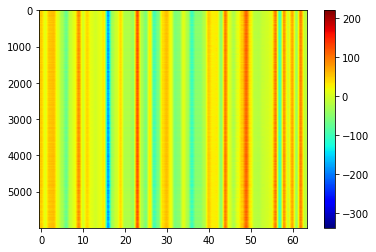

In [17]:
plt.imshow(ext_data['train']['features'][:,:64], cmap='jet', aspect='auto')
plt.colorbar()

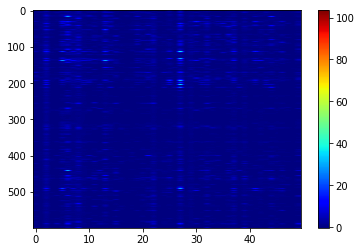

In [26]:
plt.imshow(ext_data['valid_source']['features'][:,2050:2100], cmap='jet', aspect='auto')
plt.colorbar()

In [24]:
ext_data['valid_source']['features'].shape

(600, 3024)